In [1]:
cd ..

C:\Users\ALYEG\Documents\GitHub\IVISpaces


In [2]:
import GPy
import time
import copy
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Optimizer
from torch.optim.sgd import SGD

from torchvision import datasets, transforms
from torchvision.utils import make_grid

%config InlineBackend.figure_format = 'svg'

from torch.utils.data import Dataset

from Metrics import evaluate_metrics
from Experiments import get_setup


In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
def to_variable(var=(), cuda=True, volatile=False):
    out = []
    for v in var:
        
        if isinstance(v, np.ndarray):
            v = torch.from_numpy(v).type(torch.FloatTensor)

        if not v.is_cuda and cuda:
            v = v.to(device)

        if not isinstance(v, Variable):
            v = Variable(v, volatile=volatile)

        out.append(v)
    return out

In [5]:
def log_gaussian_loss(output, target, sigma, no_dim):
    exponent = -0.5*(target - output)**2/sigma**2
    log_coeff = -no_dim*torch.log(sigma) - 0.5*no_dim*np.log(2*np.pi)
    
    return - (log_coeff + exponent).sum()


def get_kl_divergence(weights, prior, varpost):
    prior_loglik = prior.loglik(weights)
    
    varpost_loglik = varpost.loglik(weights)
    varpost_lik = varpost_loglik.exp()
    
    return (varpost_lik*(varpost_loglik - prior_loglik)).sum()


class gaussian:
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
        
    def loglik(self, weights):
        exponent = -0.5*(weights - self.mu)**2/self.sigma**2
        log_coeff = -0.5*(np.log(2*np.pi) + 2*np.log(self.sigma))
        
        return (exponent + log_coeff).sum()
        

In [6]:
class MC_Dropout_Model(nn.Module):
    def __init__(self, input_dim, output_dim, num_units, drop_prob):
        super(MC_Dropout_Model, self).__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.drop_prob = drop_prob
        
        # network with two hidden and one output layer
        self.layer1 = nn.Linear(input_dim, num_units)
        self.layer2 = nn.Linear(num_units, 2*output_dim)
        
        self.activation = nn.ReLU(inplace = True)

    
    def forward(self, x):
        
        x = x.view(-1, self.input_dim)
        
        x = self.layer1(x)
        x = self.activation(x)
        
        x = F.dropout(x, p=self.drop_prob, training=True)
        
        x = self.layer2(x)
        
        return x

In [7]:
class MC_Dropout_Wrapper:
    def __init__(self, network, learn_rate, batch_size, weight_decay):
        
        self.learn_rate = learn_rate
        self.batch_size = batch_size
        
        self.network = network
        self.network.to(device)
        
        self.optimizer = torch.optim.Adam(self.network.parameters(), lr=learn_rate, weight_decay=weight_decay)
        self.loss_func = log_gaussian_loss
    
    def fit(self, x, y):
        x, y = to_variable(var=(x, y), cuda=True)
        
        # reset gradient and total loss
        self.optimizer.zero_grad()
        
        output = self.network(x)
        loss = self.loss_func(output[:, :1], y, output[:, 1:].exp(), 1)
        
        loss.backward()
        self.optimizer.step()

        return loss
    
    def get_loss_and_rmse(self, x, y, num_samples):
        x, y = to_variable(var=(x, y), cuda=True)
        
        means, stds = [], []
        for i in range(num_samples):
            output = self.network(x)
            means.append(output[:, :1])
            stds.append(output[:, 1:].exp())
        
        means, stds = torch.cat(means, dim=1), torch.cat(stds, dim=1)
        mean = means.mean(dim=-1)[:, None]
        std = ((means.var(dim=-1) + stds.mean(dim=-1)**2)**0.5)[:, None]
        loss = self.loss_func(mean, y, std, 1)
        
        rmse = ((mean - y)**2).mean()**0.5

        return loss.detach().cpu(), rmse.detach().cpu()

In [8]:
def toy_test(x_train,x_test,y_train,number_point):
    np.random.seed(2)
    no_points = number_point
    lengthscale = 1
    variance = 1.0 
    sig_noise = 0.3
    x = torch.cat((x_train,x_test),0).numpy()
    x.sort(axis = 0)
    
    num_epochs, batch_size = 2000, len(x_train)
    
    net = MC_Dropout_Wrapper(network=MC_Dropout_Model(input_dim=1, output_dim=1, num_units=200, drop_prob=0.5),
                         learn_rate=1e-4, batch_size=batch_size, weight_decay=1e-2)
    fit_loss_train = np.zeros(num_epochs)
    best_net, best_loss = None, float('inf')
    nets, losses = [], []
    for i in range(num_epochs):
        loss = net.fit(x_train, y_train)
        losses.append(loss)

        if i % 200 == 0:
            print('Epoch: %4d, Train loss = %7.3f' % (i, loss.cpu().data.numpy()/batch_size))

    return net, losses




In [9]:
def show_graph():
    samples = []
    noises = []
    for i in range(1000):
        preds = net.network.forward(torch.linspace(-2, 2, 200).to(device)).cpu().data.numpy()
        samples.append(preds[:, 0])
        noises.append(np.exp(preds[:, 1]))
    
    samples = np.array(samples)
    noises = np.array(noises)
    means = (samples.mean(axis = 0)).reshape(-1)

    aleatoric = (noises**2).mean(axis = 0)**0.5
    epistemic = (samples.var(axis = 0)**0.5).reshape(-1)
    total_unc = (aleatoric**2 + epistemic**2)**0.5


    c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
         '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

    plt.figure(figsize = (6, 5))
    plt.style.use('default')
    plt.scatter(x_train, y_train, s = 10, marker = 'x', color = 'black', alpha = 0.5)
    plt.fill_between(np.linspace(-2, 2, 200), means + aleatoric, means + total_unc, color = c[0], alpha = 0.3, label = 'Epistemic + Aleatoric')
    plt.fill_between(np.linspace(-2, 2, 200), means - total_unc, means - aleatoric, color = c[0], alpha = 0.3)
    plt.fill_between(np.linspace(-2, 2, 200), means - aleatoric, means + aleatoric, color = c[1], alpha = 0.4, label = 'Aleatoric')
    plt.plot(np.linspace(-2, 2, 200), means, color = 'black', linewidth = 1)
    plt.xlim([-2, 2])
    plt.ylim([-5, 7])
    plt.xlabel('$x$', fontsize=30)
    plt.title('MC dropout', fontsize=40)
    plt.tick_params(labelsize=10)
    plt.xticks(np.arange(-2, 2.1, 1))
    plt.yticks(np.arange(-4, 7, 2))
    plt.gca().set_yticklabels([])
    plt.gca().yaxis.grid(alpha=0.3)
    plt.gca().xaxis.grid(alpha=0.3)
    plt.savefig('mc_dropout_hetero.pdf', bbox_inches = 'tight')

    #files.download("mc_dropout_hetero.pdf")

    plt.show()

# UCI Dataset #

In [10]:
class MC_Dropout_Model_UCI(nn.Module):
    def __init__(self, input_dim, output_dim, num_units, drop_prob):
        super(MC_Dropout_Model_UCI, self).__init__()
        

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.drop_prob = drop_prob
        
        # network with two hidden and one output layer
        self.layer1 = nn.Linear(input_dim, num_units)
        self.layer2 = nn.Linear(num_units, 2*output_dim)
        
        self.activation = nn.ReLU()

    
    def forward(self, x):
        
        x = x.view(-1, self.input_dim)
        
        x = self.layer1(x)
        x = self.activation(x)
        
        x = F.dropout(x, p=self.drop_prob, training=True)
        
        x = self.layer2(x)
        
        return x

def train_mc_dropout(x_train,y_train,x_test,y_test, y_stds, drop_prob, num_epochs, num_units, learn_rate, weight_decay, log_every, num_samples):
    in_dim = x_train.shape[1]
    out_dim = y_train.shape[1]
    train_logliks, test_logliks = [], []
    train_rmses, test_rmses = [], []
    
    net = MC_Dropout_Wrapper(network=MC_Dropout_Model_UCI(input_dim=in_dim, output_dim=out_dim, num_units=num_units, drop_prob=drop_prob),
                                 learn_rate=learn_rate, batch_size=batch_size, weight_decay=weight_decay)

    losses = []
    fit_loss_train = np.zeros(num_epochs)

    for i in range(num_epochs):
        loss = net.fit(x_train, y_train)
        losses.append(loss)
                
        if i % log_every == 0 or i == num_epochs - 1:
            test_loss, rmse = net.get_loss_and_rmse(x_test, y_test, num_samples=num_samples)
            test_loss, rmse = test_loss.cpu().data.numpy(), rmse.cpu().data.numpy()

            print('Epoch: %4d, Train loss: %6.3f Test loss: %6.3f RMSE: %.3f' %
                    (i, loss.cpu().data.numpy()/len(x_train), test_loss/len(x_test), rmse*y_stds[0].cpu().data.numpy()))


    train_loss, train_rmse = net.get_loss_and_rmse(x_train, y_train, num_samples=num_samples)
    test_loss, test_rmse = net.get_loss_and_rmse(x_test, y_test, num_samples=num_samples)
        
    train_logliks.append((train_loss.cpu().data.numpy()/len(x_train) + np.log(y_stds)[0]))
    test_logliks.append((test_loss.cpu().data.numpy()/len(x_test) + np.log(y_stds)[0]))

    train_rmses.append(y_stds[0]*train_rmse.cpu().data.numpy())
    test_rmses.append(y_stds[0]*test_rmse.cpu().data.numpy())
        


    print('Train log. lik. = %6.3f +/- %6.3f' % (-np.array(train_logliks).mean(), np.array(train_logliks).var()**0.5))
    print('Test  log. lik. = %6.3f +/- %6.3f' % (-np.array(test_logliks).mean(), np.array(test_logliks).var()**0.5))
    print('Train RMSE      = %6.3f +/- %6.3f' % (np.array(train_rmses).mean(), np.array(train_rmses).var()**0.5))
    print('Test  RMSE      = %6.3f +/- %6.3f' % (np.array(test_rmses).mean(), np.array(test_rmses).var()**0.5))
    
    return net , losses

# Setup(Toy) #

In [11]:
#toy datasets : ['foong','foong_sparse', 'foong_mixed','foong2d']  foong_mixed is not working! foong 2d needs modification in code?! 
dataset='foong' 

setup_ = get_setup(dataset) #get a module
setup=setup_.Setup(device) #get an object

x_train, y_train=setup.train_data() #scaled_data
x_test, y_test=setup.test_data()
input_dim=x_train.shape[1]
output_dim=y_train.shape[1]
print('input dim: {}'.format(input_dim))
print('output dim: {}'.format(output_dim))
print('nb of train samples: {}'.format(len(x_train)))

#scalar used to scale the train target to have std=1
std_y_train = torch.tensor(1.)
if hasattr(setup, '_scaler_y'):
    print('scaler target: {}'.format(setup._scaler_y.scale_.item()))
    std_y_train=torch.tensor(setup._scaler_y.scale_, device=device).squeeze().float()

input dim: 1
output dim: 1
nb of train samples: 120


In [12]:
net,losses=toy_test(x_train=x_train, x_test=x_test, y_train=y_train,number_point=len(x_train)+len(x_test))

Epoch:    0, Train loss =   1.337
Epoch:  200, Train loss =   0.774
Epoch:  400, Train loss =   0.679
Epoch:  600, Train loss =   0.520
Epoch:  800, Train loss =   0.381
Epoch: 1000, Train loss =   0.226
Epoch: 1200, Train loss =   0.192
Epoch: 1400, Train loss =   0.185
Epoch: 1600, Train loss =   0.126
Epoch: 1800, Train loss =   0.102


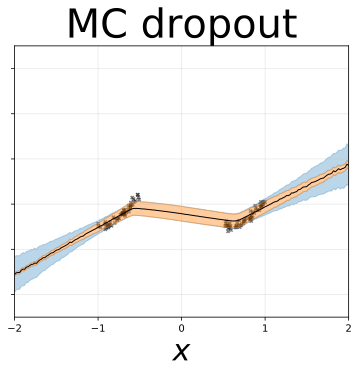

In [13]:
show_graph()

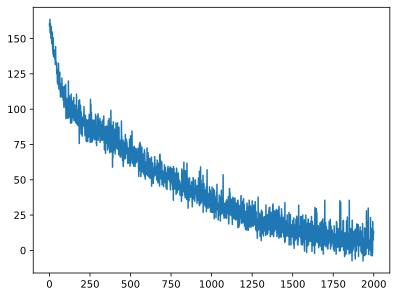

In [14]:
plt.plot(torch.arange(0,len(losses),1),torch.as_tensor(losses))

# Setup(UCI) #

In [23]:
#UCI datasets: ['boston','concrete', 'energy', 'powerplant',  'wine', 'yacht', 'protein', 'navalC'] 
dataset='concrete' 

setup_ = get_setup(dataset) #get a module
setup=setup_.Setup(device) #get an object

x_train, y_train=setup.train_data() #scaled_data
x_test, y_test=setup.test_data()
input_dim=x_train.shape[1]
output_dim=y_train.shape[1]
print('input dim: {}'.format(input_dim))
print('output dim: {}'.format(output_dim))
print('nb of train samples: {}'.format(len(x_train)))

#scalar used to scale the train target to have std=1
std_y_train = torch.tensor(1.)
if hasattr(setup, '_scaler_y'):
    print('scaler target: {}'.format(setup._scaler_y.scale_.item()))
    std_y_train=torch.tensor(setup._scaler_y.scale_, device=device).float()

input dim: 8
output dim: 1
nb of train samples: 927
scaler target: 16.853646929724285


In [24]:
#predictive model
layerwidth=50
activation=nn.ReLU()
drop_prob=0.05
num_epochs=20000
batch_size = len(x_train)
learn_rate=1e-3 #1e-5 for powerplant , navalC and 1e-6 for protein
weight_decay= 1e-1/(len(x_train)+len(x_test))**0.5 #5e-7    #
num_samples=50
log_every=50
print(learn_rate,weight_decay)

0.001 0.003115884764248779


In [25]:
net , losses = train_mc_dropout(x_train=x_train,y_train=y_train, x_test=x_test,y_test=y_test, y_stds=std_y_train, drop_prob=drop_prob, num_epochs=num_epochs, num_units=layerwidth, learn_rate=learn_rate,
                       weight_decay=weight_decay, num_samples=num_samples, log_every=log_every)

Epoch:    0, Train loss:  1.418 Test loss:  1.355 RMSE: 15.942
Epoch:   50, Train loss:  0.999 Test loss:  0.939 RMSE: 11.198
Epoch:  100, Train loss:  0.836 Test loss:  0.783 RMSE: 9.803
Epoch:  150, Train loss:  0.669 Test loss:  0.643 RMSE: 8.549
Epoch:  200, Train loss:  0.569 Test loss:  0.563 RMSE: 7.922
Epoch:  250, Train loss:  0.403 Test loss:  0.480 RMSE: 7.514
Epoch:  300, Train loss:  0.342 Test loss:  0.433 RMSE: 7.412
Epoch:  350, Train loss:  0.268 Test loss:  0.387 RMSE: 7.209
Epoch:  400, Train loss:  0.231 Test loss:  0.364 RMSE: 7.146
Epoch:  450, Train loss:  0.198 Test loss:  0.353 RMSE: 7.032
Epoch:  500, Train loss:  0.205 Test loss:  0.331 RMSE: 6.851
Epoch:  550, Train loss:  0.155 Test loss:  0.322 RMSE: 6.854
Epoch:  600, Train loss:  0.146 Test loss:  0.325 RMSE: 6.920
Epoch:  650, Train loss:  0.150 Test loss:  0.298 RMSE: 6.710
Epoch:  700, Train loss:  0.109 Test loss:  0.297 RMSE: 6.764
Epoch:  750, Train loss:  0.113 Test loss:  0.291 RMSE: 6.698
Epoch:

Epoch: 6650, Train loss: -0.027 Test loss:  0.161 RMSE: 6.191
Epoch: 6700, Train loss: -0.032 Test loss:  0.159 RMSE: 6.073
Epoch: 6750, Train loss: -0.062 Test loss:  0.173 RMSE: 6.205
Epoch: 6800, Train loss: -0.029 Test loss:  0.161 RMSE: 6.162
Epoch: 6850, Train loss: -0.030 Test loss:  0.165 RMSE: 6.098
Epoch: 6900, Train loss: -0.049 Test loss:  0.172 RMSE: 6.200
Epoch: 6950, Train loss: -0.057 Test loss:  0.157 RMSE: 6.162
Epoch: 7000, Train loss: -0.029 Test loss:  0.158 RMSE: 6.163
Epoch: 7050, Train loss: -0.059 Test loss:  0.164 RMSE: 6.169
Epoch: 7100, Train loss: -0.003 Test loss:  0.168 RMSE: 6.145
Epoch: 7150, Train loss: -0.044 Test loss:  0.165 RMSE: 6.182
Epoch: 7200, Train loss: -0.052 Test loss:  0.174 RMSE: 6.277
Epoch: 7250, Train loss: -0.067 Test loss:  0.176 RMSE: 6.193
Epoch: 7300, Train loss: -0.055 Test loss:  0.157 RMSE: 6.160
Epoch: 7350, Train loss: -0.018 Test loss:  0.158 RMSE: 6.228
Epoch: 7400, Train loss: -0.027 Test loss:  0.162 RMSE: 6.173
Epoch: 7

Epoch: 13250, Train loss: -0.078 Test loss:  0.125 RMSE: 6.063
Epoch: 13300, Train loss: -0.081 Test loss:  0.133 RMSE: 6.084
Epoch: 13350, Train loss: -0.114 Test loss:  0.129 RMSE: 6.186
Epoch: 13400, Train loss: -0.085 Test loss:  0.123 RMSE: 6.029
Epoch: 13450, Train loss: -0.080 Test loss:  0.137 RMSE: 6.173
Epoch: 13500, Train loss: -0.058 Test loss:  0.128 RMSE: 6.114
Epoch: 13550, Train loss: -0.083 Test loss:  0.123 RMSE: 5.993
Epoch: 13600, Train loss: -0.042 Test loss:  0.104 RMSE: 5.948
Epoch: 13650, Train loss: -0.069 Test loss:  0.127 RMSE: 6.046
Epoch: 13700, Train loss: -0.074 Test loss:  0.123 RMSE: 6.075
Epoch: 13750, Train loss: -0.093 Test loss:  0.131 RMSE: 6.180
Epoch: 13800, Train loss: -0.092 Test loss:  0.129 RMSE: 6.100
Epoch: 13850, Train loss: -0.091 Test loss:  0.130 RMSE: 6.100
Epoch: 13900, Train loss: -0.073 Test loss:  0.127 RMSE: 6.042
Epoch: 13950, Train loss: -0.089 Test loss:  0.142 RMSE: 6.119
Epoch: 14000, Train loss: -0.088 Test loss:  0.127 RMSE

Epoch: 19800, Train loss: -0.072 Test loss:  0.134 RMSE: 6.035
Epoch: 19850, Train loss: -0.105 Test loss:  0.114 RMSE: 6.124
Epoch: 19900, Train loss: -0.110 Test loss:  0.133 RMSE: 6.101
Epoch: 19950, Train loss: -0.105 Test loss:  0.116 RMSE: 6.107
Epoch: 19999, Train loss: -0.111 Test loss:  0.130 RMSE: 6.136
Train log. lik. = -2.662 +/-  0.000
Test  log. lik. = -2.975 +/-  0.000
Train RMSE      =  4.498 +/-  0.000
Test  RMSE      =  6.231 +/-  0.000


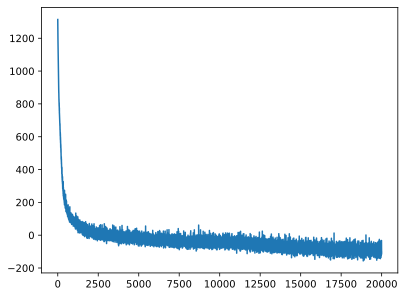

In [26]:
plt.plot(torch.arange(0,len(losses),1),torch.as_tensor(losses))

# Results on test #

In [27]:
nb_predictors=num_samples
samples = []
noises = []
for i in range(nb_predictors):
    preds = net.network.forward(x_test).cpu().data.numpy()
    samples.append(preds[:, 0])
    noises.append(np.exp(preds[:, 1]))
    
samples = np.array(samples)
noises = np.array(noises)

means = torch.Tensor(samples.mean(axis = 0)).view(1,-1,1)

aleatoric = torch.Tensor((noises**2).mean(axis = 0)**0.5)
epistemic = torch.Tensor(samples.var(axis = 0)**0.5).view(-1,1)
total_unc = (aleatoric**2 + epistemic**2)**0.5



y_pred = means + epistemic * torch.randn(nb_predictors,1,1) 


sigma_noise = aleatoric.view(1,-1,1)





#sigma_noise.size()
#example
#nb_predictors=100
#nb_test_points=5

#y_pred=torch.randn(100,5,1) #nb_predictors x nb_tests x 1


#sigma_noise=0.5+torch.rand(100,5,1) #nb_predictors x nb_tests x 1 if heteroscedastic
#sigma_noise=0.5+torch.rand(100,1,1) #nb_predictors x 1 x 1 if homeoscedastic depending on predictors
#sigma_noise=0.5+torch.rand(1,1,1) # 1 x 1 x 1 if homeoscedastic uniform on predictors

#y_test=2*torch.randn(5,1)

#calculate metrics
#(RMSE, sqrt(std on test)), 
#(LPP (loglikelihood), std on test), (bigger is better)
# PICP Predictive Interval Covering Probability (theoretical best value 0.95)
# MPIW, Mean Predictive Interval Width (smaller is better)
evaluate_metrics(y_pred,sigma_noise, y_test, std_y_train, device='cpu', std=True)

{'RMSE': (6.090027809143066, 9.407295227050781),
 'LPP': (-0.1439477503299713, 0.8085149526596069),
 'WAIC': -0.41406700015068054,
 'PICP': 0.9320388436317444,
 'MPIW': 20.854286193847656}